# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# RFM

In [1]:
from sklearn import preprocessing
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import datetime
from sklearn.cluster import KMeans
%matplotlib inline


In [2]:
eshop = pd.read_csv('eshop.csv')  

In [3]:
eshop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22408 entries, 0 to 22407
Data columns (total 4 columns):
Customer ID    22408 non-null int64
Date           22408 non-null object
Subtotal       22408 non-null float64
Country        22405 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 700.3+ KB


In [4]:
today = datetime.datetime(2015,12,19,0,0,0,0)

In [5]:
eshop['Date'] = pd.to_datetime(eshop['Date'], infer_datetime_format=True)

In [6]:
rfm = eshop.groupby(by=['Customer ID']).agg({'Date':max, 'Subtotal':['count', sum] })
rfm.columns = rfm.columns.droplevel(0)
rfm['max'] = (today - rfm['max']).apply(lambda x: x.days) 

In [7]:
rfm = rfm.rename(columns={"max": "r","count":"f" ,"sum": "m"})

In [8]:
X = rfm.copy()
print(X.shape)

(12829, 3)


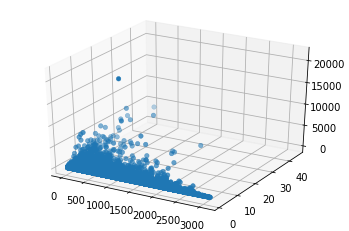

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X['r'], X['f'], X['m'], cmap='viridis', linewidth=0.5);

# k-means

## k

použijeme hodnotu účelové funkce vzávislosti na  𝑘, kde nam pomůže knihovna yellowbrick která nám sama najde bod zlomu

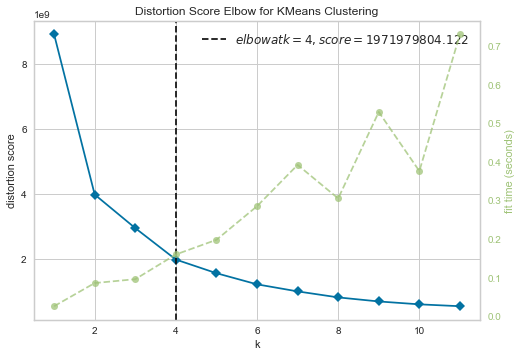

In [10]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        
visualizer.show() 

[1 0 0 ... 1 1 1]
[[2.04835141e+03 1.28341939e+00 8.42627625e+01]
 [3.30929396e+02 2.16256265e+00 1.93426093e+02]
 [1.16415478e+03 1.54822227e+00 1.21345154e+02]
 [3.20789474e+02 1.29473684e+01 4.34233474e+03]]


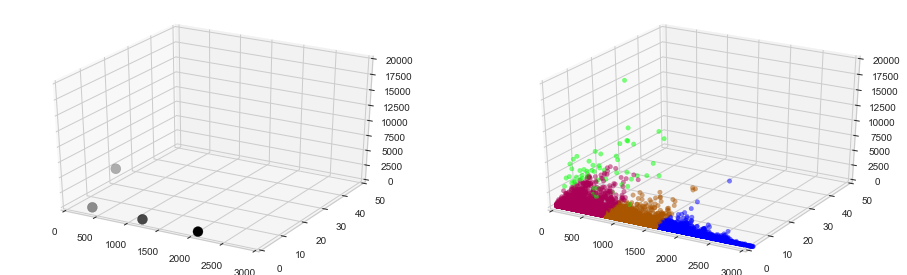

In [11]:
from sklearn.cluster import KMeans

k = 4

kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)

print(kmeans.labels_)

print(kmeans.cluster_centers_)

fig = plt.figure(figsize=plt.figaspect(0.3))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_xlim((0,3000))
ax1.set_ylim((0,50))
ax1.set_zlim((0,20000))
ax1.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], c = 'black', s=100)

ax2.set_xlim((0,3000))
ax2.set_ylim((0,50))
ax2.set_zlim((0,20000))
ax2.scatter(X['r'], X['f'], X['m'], c=kmeans.labels_, cmap='brg', alpha=0.5)


# Silhouette

Pro n_clusters = 2 Průmerné Silhouette score : 0.5518760684923996
Pro n_clusters = 3 Průmerné Silhouette score : 0.49330160294688685
Pro n_clusters = 4 Průmerné Silhouette score : 0.5075624264152807
Pro n_clusters = 5 Průmerné Silhouette score : 0.5203005889339968
Pro n_clusters = 6 Průmerné Silhouette score : 0.47904824226965537


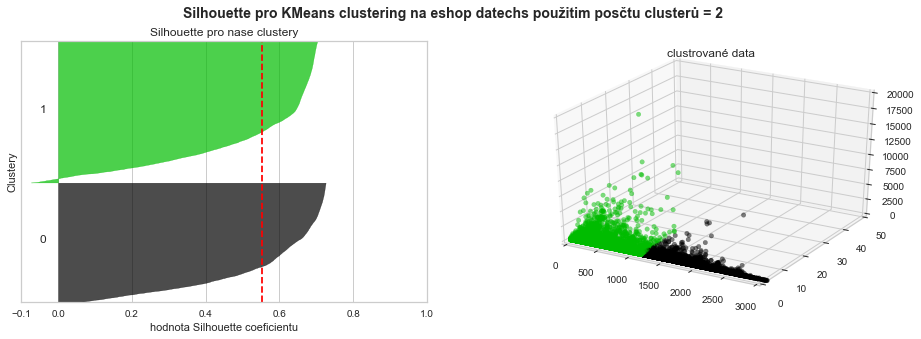

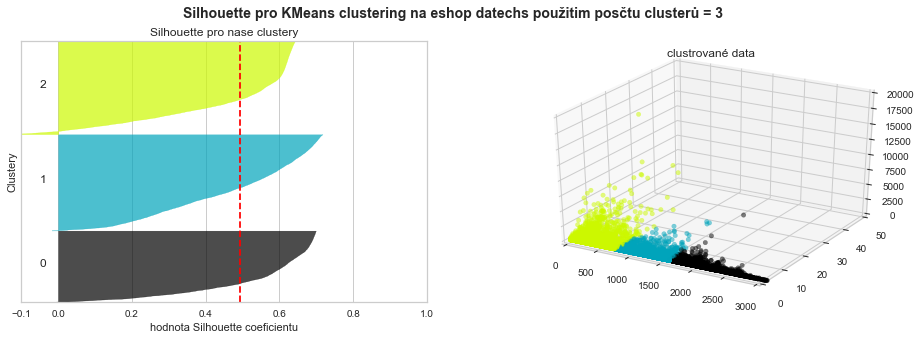

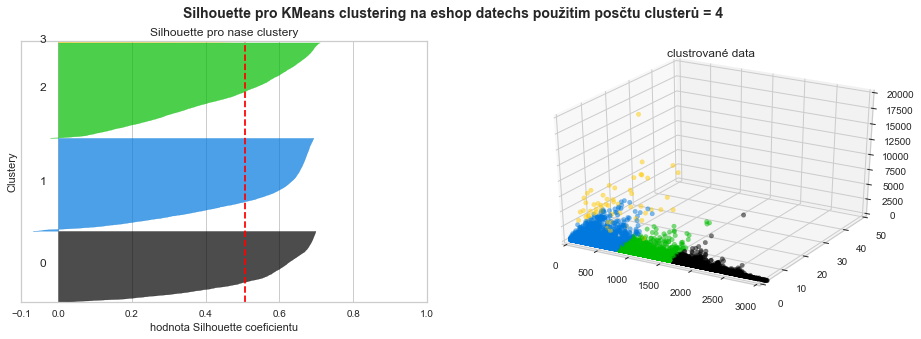

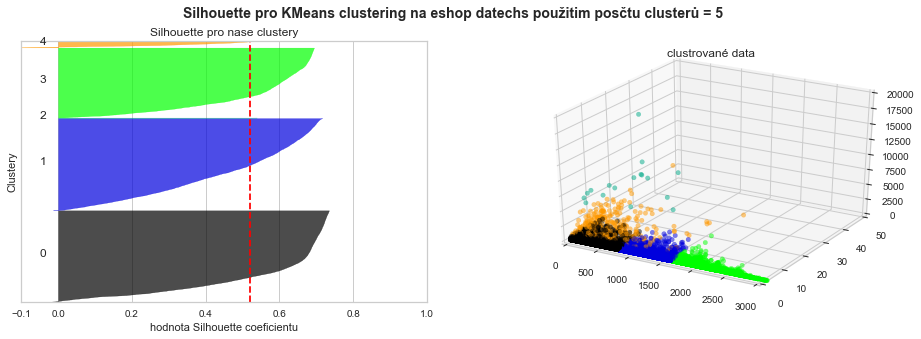

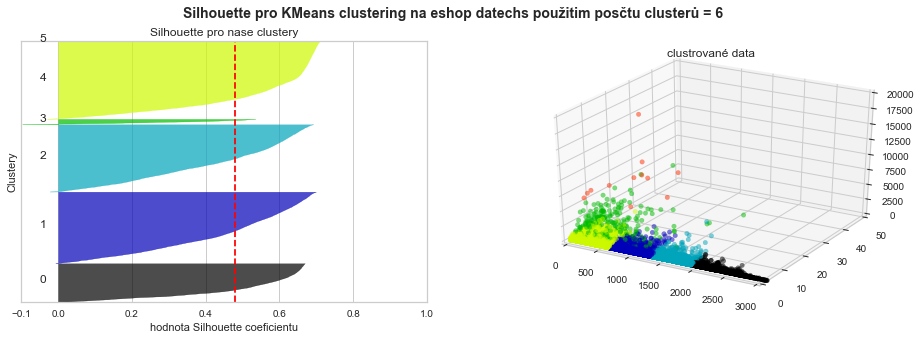

In [70]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    fig = plt.figure(figsize=plt.figaspect(0.3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    #metoda Silhouette muze vyuzivat interval od -1 do 1, 
    #v tomto případě si však vystačím s vizualizací -0.1 do 1
    ax1.set_xlim([-0.1, 1])
    
    #pro lepsi vizualni odliseni clusteru
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #KNN
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X)

    #silhouette_score nam vrací přůměrnou hdnotu pro všechny zakazníky, jak moc sedí do daného clusteru
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Pro n_clusters =", n_clusters,
          "Průmerné Silhouette score :", silhouette_avg)

    #spočítá konkrétní hodnoty pro zákazníky
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        #vezme vsechny zakazniky z daneho clusteru i a seradi je
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("Silhouette pro nase clustery")
    ax1.set_xlabel("hodnota Silhouette coeficientu")
    ax1.set_ylabel("Clustery")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.set_xlim((0,3000))
    ax2.set_ylim((0,50))
    ax2.set_zlim((0,20000))
    ax2.scatter(X['r'], X['f'], X['m'], c=colors, cmap='brg', alpha=0.5)

    ax2.set_title("clustrované data")

    plt.suptitle(("Silhouette pro KMeans clustering na eshop datech"
                  "s použitim posčtu clusterů = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Metoda nám říká, že když mají všechny prvky vysoké scóre a nevyskytují se zde moc často prvky s nízkou nebo zápornou hodnotou, tak jsem našli správný počet clusterů. V opačném případě je jich bud málo, nebo hodně

varianta s 2ma clustery má sice vysoké číslo, ale pro můj učel není moc použitelný, protože to davá do jednoho 
clusteru zákazníky s příliš odlišnými 
hodnotami a velice nedostatečně bychom na tomto pripadě hledali superstar

tudíž nám nejlépe vycházejí varianty pro 4 a 5 clusterů, ale varianta s 5ti má hodnoty s o dost větší zápornou hodnotou v 5te clusteru tudíž bych zvolil variantu se 4mi

# Standardizace

Standardizace je zde na miste jelikoz je velký rozdíl v hodnotách, tudíž by se nám stalo, že napr parametr f by nám model ovlivnoval naprosto minimálně oproti zbylím

In [12]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

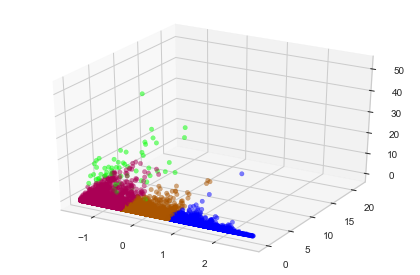

In [13]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_scaled[:,0], X_scaled[:,1], X_scaled[:,2],c=kmeans.labels_, cmap='brg', alpha=0.5)

Tohle stále nevypadá nejlíp, proto jsem se rozhodl pro další úpravu tak, ze vsechny hodnoty rozeškáluji do intervalu (-10 : 10)

díky tomuto se všechny hodnoty dostanou do intervalu od -10 do 10

In [14]:
X_s = X_scaled

X_s[:,0] = (X_scaled[:,0] / max(X_scaled[:,0])) * 10
X_s[:,1] = (X_scaled[:,1] / max(X_scaled[:,1])) * 10
X_s[:,2] = (X_scaled[:,2] / max(X_scaled[:,2])) * 10


# k-means na standardizovaných datech

In [15]:
kmeans_s = KMeans(n_clusters = k, random_state = 1).fit(X_s)


Bohužel vidíme, že standardizace v posledním kroku nám do nejlepší skupiny přidal i spoustu nežádoucich zákazníků, kteří nemají tak dobré vlastnosti, tudíž by bylo lepší využít výsledek z preprocessing.StandardScaler()

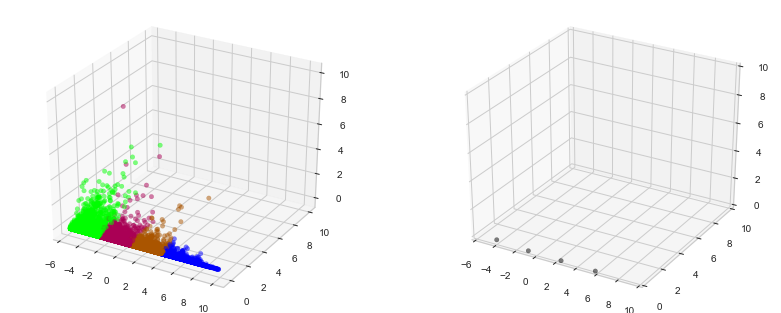

In [16]:
fig = plt.figure(figsize=plt.figaspect(0.4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_s[:,0], X_s[:,1], X_s[:,2],c=kmeans_s.labels_, cmap='brg', alpha=0.5)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_xlim((-6,10))
ax2.set_ylim((0,10))
ax2.set_zlim((0,10))
ax2.scatter(kmeans_s.cluster_centers_[:,0], kmeans_s.cluster_centers_[:,1], kmeans_s.cluster_centers_[:,2], c='black', cmap='brg', alpha=0.5)

# superstar

použije Euklidovskou vzdálenost a budeme hledat cluster, který je nejblíže od bodu (min r, max f, max m), předpokládáme pozici superzákazníka, který je ve všem nejlepší.

In [44]:
min_r = max(min(X.r), 1)
max_f = max(X.f)
max_m = max(X.m)

def euklid(cluster):
    return ((min_r - cluster[0]) / min_r )**2 + ((max_f - cluster[1]) / max_f)**2 + ((max_m - cluster[2]) / max_m)**2

1 45 21392.379999999997


nejmensi vzdalenost od naseho idealu

In [55]:
mini = 1000000
ind = 0
for i in range(0, len(kmeans.cluster_centers_)):
    if(euklid(kmeans.cluster_centers_[i]) < mini):
        ind = i
        mini = euklid(kmeans.cluster_centers_[i])
print(ind)

3


# vysledne superstar

ted už je to zobrazeno jen na nepřescalovaných datech

In [46]:
superstar_rfm = rfm[kmeans.labels_ == ind]
other_rfm = rfm[kmeans.labels_ != ind]

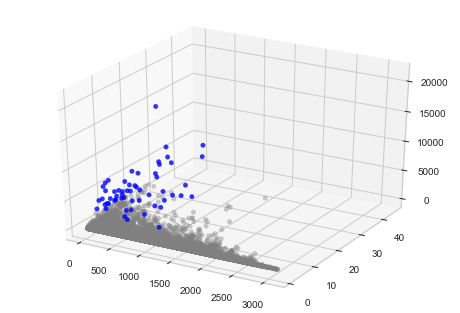

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(superstar_rfm['r'], superstar_rfm['f'], superstar_rfm['m'], c='blue', alpha=0.8)
ax.scatter(other_rfm['r'], other_rfm['f'], other_rfm['m'], c='gray', alpha=0.4)